In [33]:
# Import additional libraries for ARIMA modeling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import seaborn as sns
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

Number of missing values in Close: 0

Checking stationarity of original series:
ADF Test for Original Series
ADF Statistic: -0.6307881317051028
p-value: 0.8638723239459678
Critical Values:
	1%: -3.4323643041051666
	5%: -2.862429999065346
	10%: -2.5672437656428793

The series is non-stationary (fail to reject H0)

Applying first-order differencing...


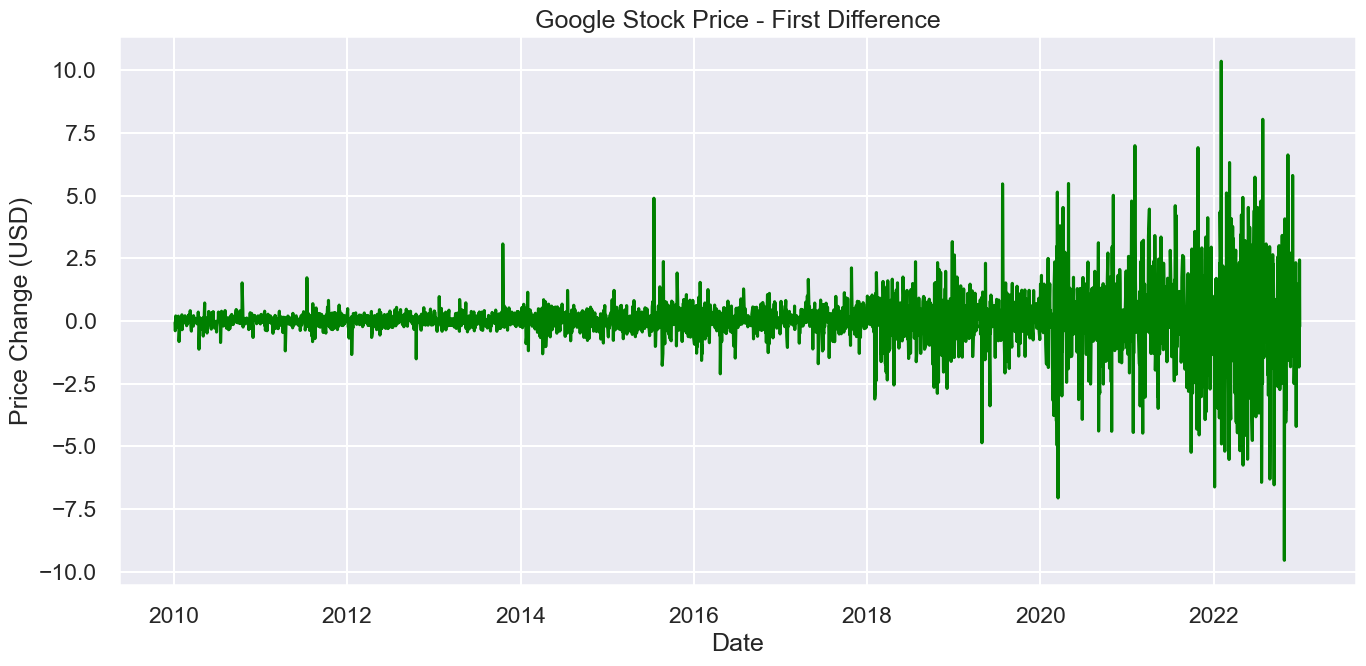

ADF Test for Differenced Series
ADF Statistic: -13.143871907569642
p-value: 1.4112618457204358e-24
Critical Values:
	1%: -3.4323643041051666
	5%: -2.862429999065346
	10%: -2.5672437656428793

The series is stationary (reject H0)


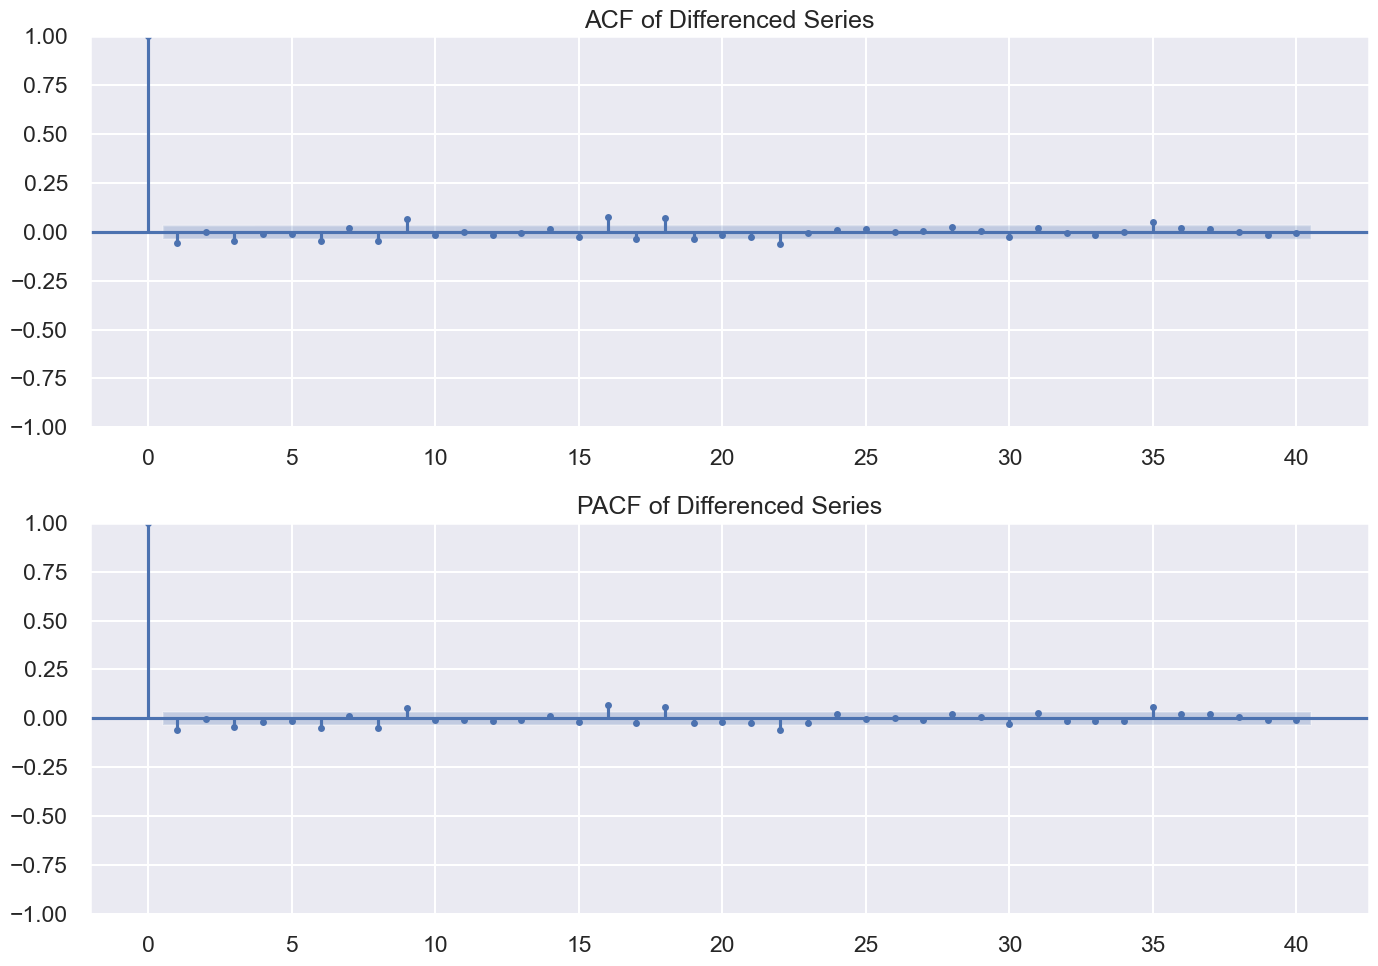


Train set size: 2617
Test set size: 655

Finding optimal ARIMA parameters using auto_arima...
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5165.644, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5129.826, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5130.894, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5166.421, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5131.783, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5131.798, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5133.395, Time=0.98 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=5131.357, Time=0.05 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 1.764 seconds

Best ARIMA model:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2617
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -2561.913
D

In [34]:
# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_context("talk")

# Load the Google stock price data
file_path = 'Google_Stock_Train (2010-2022).csv'
df = pd.read_csv(file_path)

# Convert the Date column to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Check for missing values
print(f"Number of missing values in Close: {df['Close'].isna().sum()}")
# Fill any missing values in the input data
df['Close'] = df['Close'].fillna(method='ffill')

# Define ADF test function
def adf_test(series, title=''):
    print(f"ADF Test for {title}")
    result = adfuller(series, autolag='AIC')
    
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
    
    # Interpret the results
    if result[1] <= 0.05:
        print("\nThe series is stationary (reject H0)")
        return True
    else:
        print("\nThe series is non-stationary (fail to reject H0)")
        return False

# Check stationarity of original series
print("\nChecking stationarity of original series:")
is_stationary = adf_test(df['Close'], title='Original Series')

# If the series is non-stationary, apply first-order differencing
if not is_stationary:
    print("\nApplying first-order differencing...")
    df['Close_diff'] = df['Close'].diff().dropna()
    
    # Plot the differenced series
    plt.figure(figsize=(14, 7))
    plt.plot(df['Close_diff'], color='green')
    plt.title('Google Stock Price - First Difference')
    plt.xlabel('Date')
    plt.ylabel('Price Change (USD)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Check stationarity of the differenced series
    is_diff_stationary = adf_test(df['Close_diff'].dropna(), title='Differenced Series')
    
    # ACF and PACF for differenced series to help determine p and q values
    plt.figure(figsize=(14, 10))
    
    plt.subplot(211)
    plot_acf(df['Close_diff'].dropna(), lags=40, ax=plt.gca(), 
             title='ACF of Differenced Series')
    
    plt.subplot(212)
    plot_pacf(df['Close_diff'].dropna(), lags=40, ax=plt.gca(), 
              title='PACF of Differenced Series')
    
    plt.tight_layout()
    plt.show()

# Split data into train and test sets (80% train, 20% test)
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]
print(f"\nTrain set size: {len(train)}")
print(f"Test set size: {len(test)}")

# Use auto_arima to find the best ARIMA model
print("\nFinding optimal ARIMA parameters using auto_arima...")
auto_model = auto_arima(train['Close'],
                        start_p=0, start_q=0,
                        max_p=5, max_q=5,
                        d=None,  # Let the model determine d
                        seasonal=False,
                        trace=True,
                        error_action='ignore',
                        suppress_warnings=True,
                        stepwise=True)

print("\nBest ARIMA model:")
print(auto_model.summary())

# Get the optimal p, d, q values
p, d, q = auto_model.order
print(f"\nOptimal ARIMA parameters: ARIMA({p},{d},{q})")

# Fit ARIMA model with the optimal parameters
print("\nFitting ARIMA model with optimal parameters...")
model = ARIMA(train['Close'], order=(p, d, q))
model_fit = model.fit()
print(model_fit.summary())

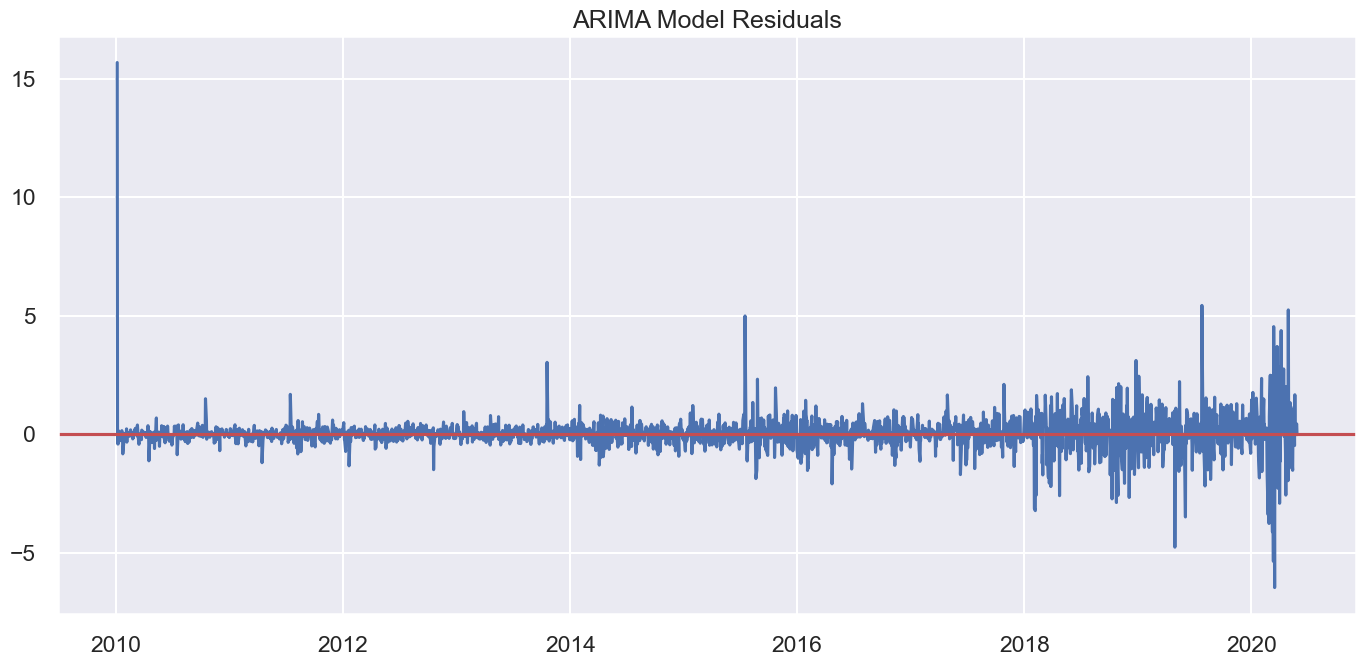

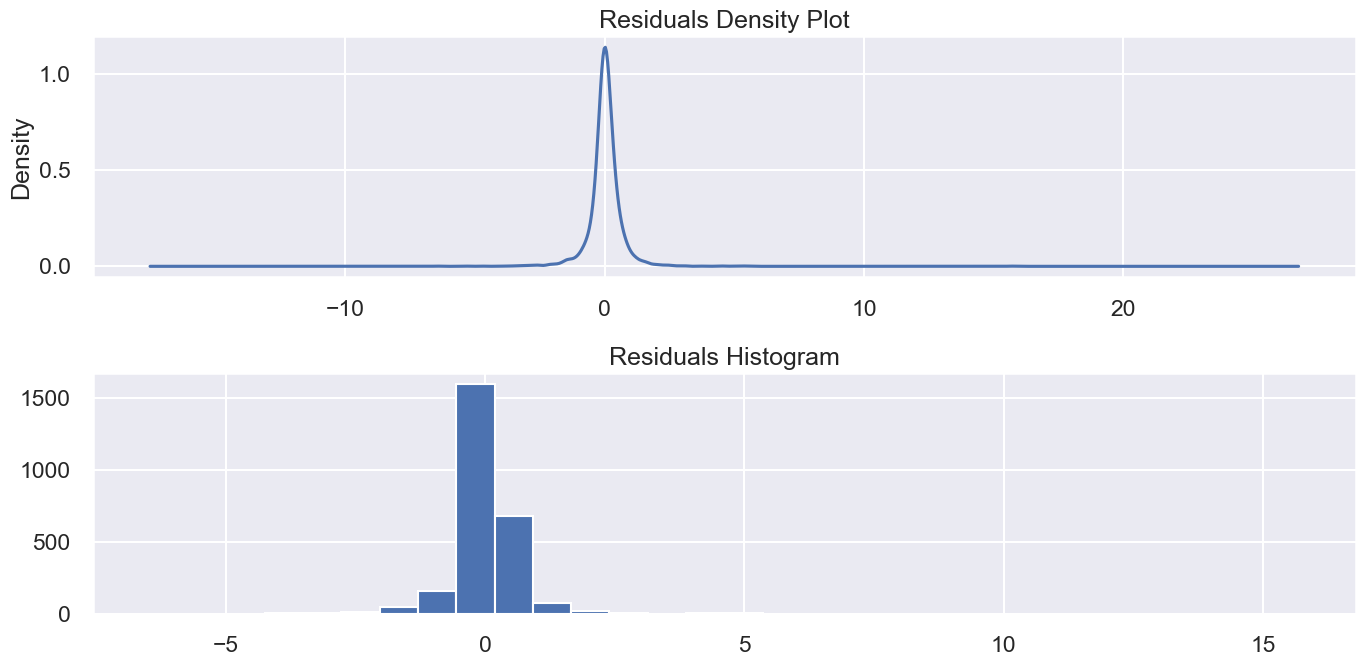

<Figure size 1400x700 with 0 Axes>

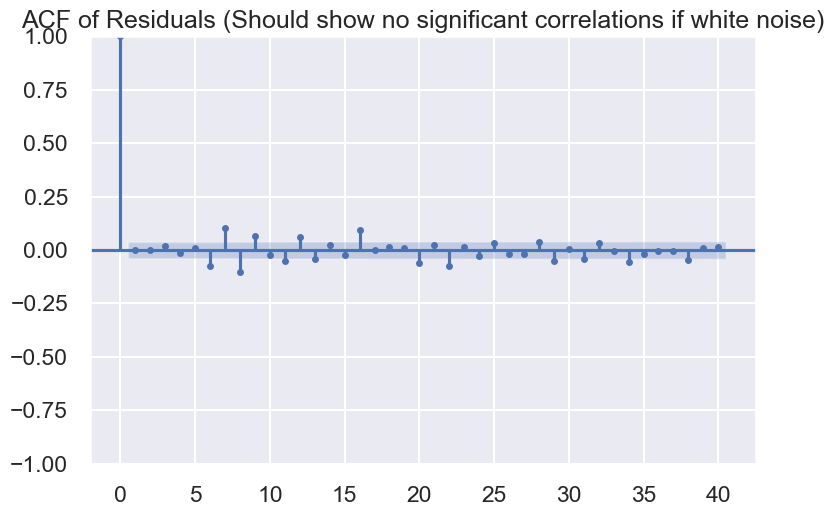

NaN values in test['Close']: 0
NaN values in forecast: 0
Number of valid comparison points: 0
Cannot calculate metrics due to insufficient valid data points


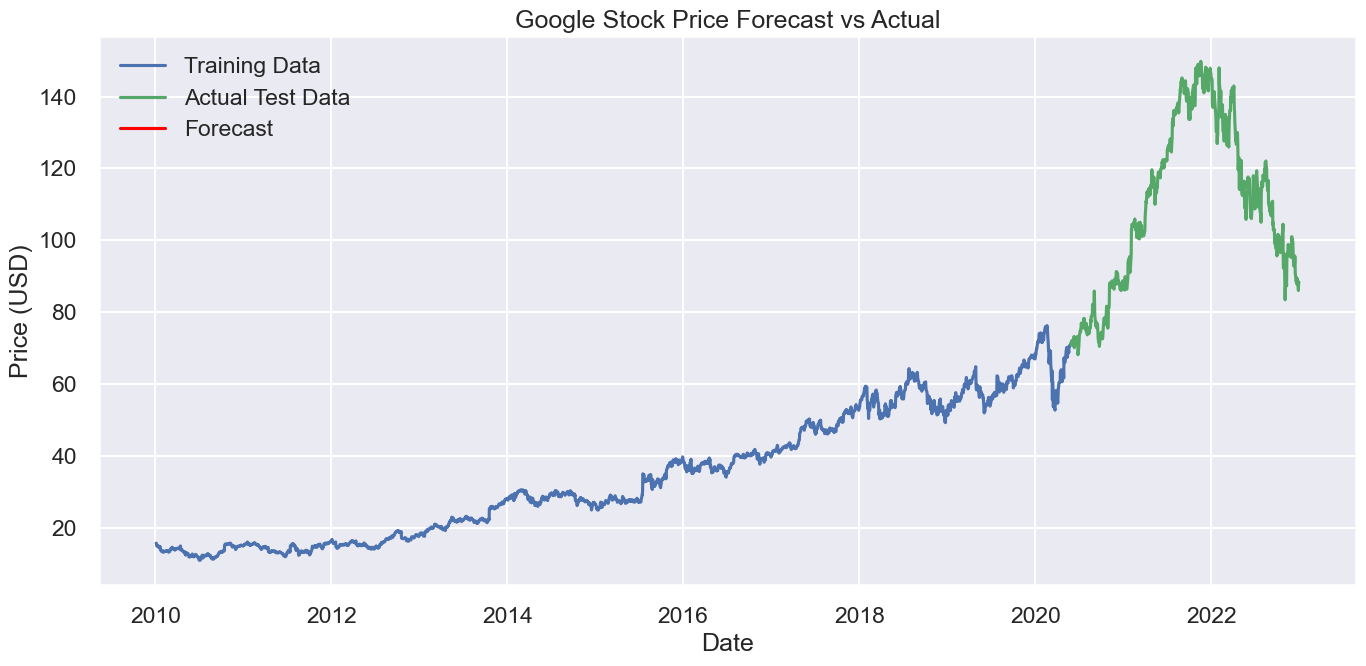

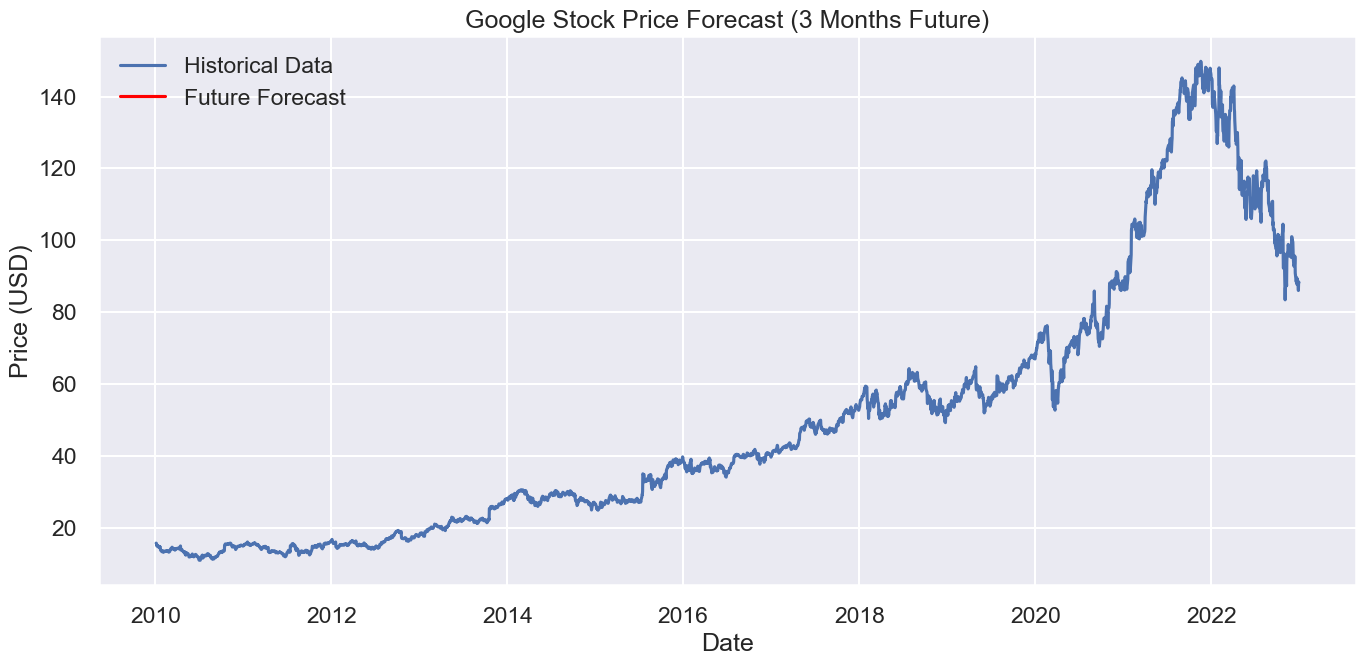

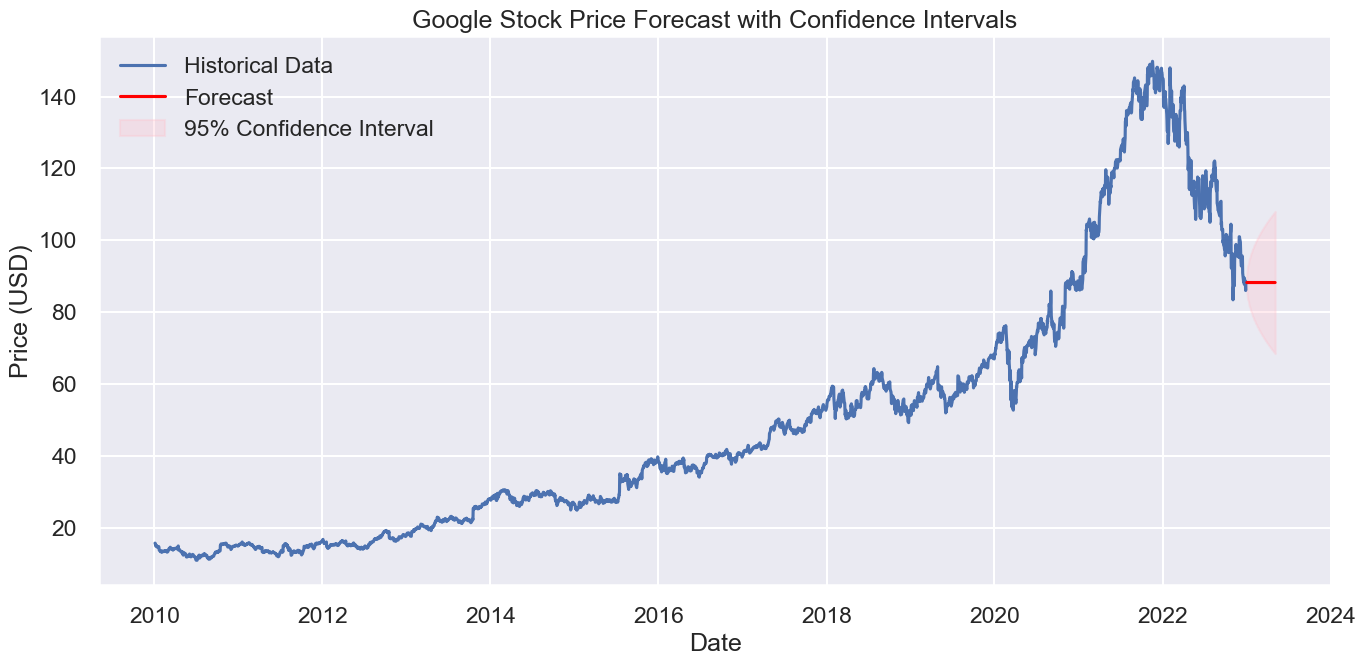

In [35]:
# Check model residuals
residuals = model_fit.resid
plt.figure(figsize=(14, 7))
plt.plot(residuals)
plt.title('ARIMA Model Residuals')
plt.axhline(y=0, color='r', linestyle='-')
plt.tight_layout()
plt.show()

# Plot residual distribution
plt.figure(figsize=(14, 7))
plt.subplot(211)
residuals.plot(kind='kde')
plt.title('Residuals Density Plot')

plt.subplot(212)
plt.hist(residuals, bins=30)
plt.title('Residuals Histogram')
plt.tight_layout()
plt.show()

# Check if residuals are white noise with ACF plot
plt.figure(figsize=(14, 7))
plot_acf(residuals, lags=40)
plt.title('ACF of Residuals (Should show no significant correlations if white noise)')
plt.tight_layout()
plt.show()

# Forecast on test set
forecast = model_fit.forecast(steps=len(test))
test_forecast = pd.DataFrame({'Forecast': forecast}, index=test.index)

# Check for NaN values before calculating metrics
print(f"NaN values in test['Close']: {test['Close'].isna().sum()}")
print(f"NaN values in forecast: {pd.isna(forecast).sum()}")

# Ensure both series are aligned and have no NaN values
valid_indices = ~(test['Close'].isna() | pd.isna(test_forecast['Forecast']))
test_actual = test.loc[valid_indices, 'Close']
test_predicted = test_forecast.loc[valid_indices, 'Forecast']

print(f"Number of valid comparison points: {len(test_actual)}")

# Calculate error metrics
if len(test_actual) > 0:
    mse = mean_squared_error(test_actual, test_predicted)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((test_actual - test_predicted) / test_actual)) * 100

    print(f"\nTest set performance metrics:")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
else:
    print("Cannot calculate metrics due to insufficient valid data points")

# Plot the forecasts against actual test data
plt.figure(figsize=(14, 7))
plt.plot(train['Close'], label='Training Data')
plt.plot(test['Close'], label='Actual Test Data')
plt.plot(test_forecast['Forecast'], label='Forecast', color='red')
plt.title('Google Stock Price Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Make future predictions (3 months)
future_steps = 90  # Approximately 3 months of trading days
future_forecast = model_fit.forecast(steps=future_steps)

# Create future dates for the forecast
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_steps, freq='B')
future_forecast_df = pd.DataFrame({'Forecast': future_forecast}, index=future_dates)

# Plot the historical data and the future forecast
plt.figure(figsize=(14, 7))
plt.plot(df['Close'], label='Historical Data')
plt.plot(future_forecast_df['Forecast'], label='Future Forecast', color='red')
plt.title('Google Stock Price Forecast (3 Months Future)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot confidence intervals for the future forecast
# Refit the model on the entire dataset for final forecast
final_model = ARIMA(df['Close'], order=(p, d, q))
final_model_fit = final_model.fit()

# Make forecast with confidence intervals
forecast_result = final_model_fit.get_forecast(steps=future_steps)
conf_int = forecast_result.conf_int()
mean_forecast = forecast_result.predicted_mean

# Plot the forecast with confidence intervals
plt.figure(figsize=(14, 7))
plt.plot(df['Close'], label='Historical Data')
plt.plot(future_dates, mean_forecast, label='Forecast', color='red')
plt.fill_between(future_dates, 
                 conf_int.iloc[:, 0], 
                 conf_int.iloc[:, 1], 
                 color='pink', alpha=0.3, label='95% Confidence Interval')
plt.title('Google Stock Price Forecast with Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()